<a href="https://colab.research.google.com/github/H4miiiid/Mushroom_Classification_BigData_Unibo/blob/main/Big_Data_CourseProject_Mushroom_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mushroom Classification Using Different Classifiers (Course Project)

In this project, we explore the Secondary Mushroom dataset and build machine learning models to predict whether a mushroom is edible or poisonous based on its observed characteristics (such as cap diameter, cap shape/color, gill properties, odor, habitat, and other attributes).

The dataset used in this notebook is secondary_data.csv (loaded with ; as the separator) and contains 61,069 samples with 20 input features (a mix of categorical attributes and a few numerical measurements like cap-diameter, stem-height, and stem-width). After preprocessing (handling missing values and encoding categorical features), we train and compare three classifiers: Logistic Regression, a Decision Tree, and a Random Forest, and evaluate them on a held-out test set.

## 1. Importing the packages

In [11]:
# Data & numerical computing
import numpy as np
import pandas as pd
from pandas.util import hash_pandas_object

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import os, urllib.request, zipfile

# Scikit-learn: preprocessing & pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

# Scikit-learn: model selection & evaluation
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_validate,
    GroupKFold, GridSearchCV
)
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report
)

# Scikit-learn: models
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Statistical tests
from scipy.stats import chi2_contingency


## 2. Download and Read the csv file of the dataset

In this step, I download the Secondary Mushroom Dataset from the UCI repository, extract the nested ZIP files, and load `secondary_data.csv` into a pandas DataFrame.

In [12]:
# 1) Download the outer zip
url = "https://archive.ics.uci.edu/static/public/848/secondary+mushroom+dataset.zip"
workdir = "/content/mushroom_data"
os.makedirs(workdir, exist_ok=True)

outer_zip = os.path.join(workdir, "secondary_mushroom_dataset.zip")
if not os.path.exists(outer_zip):
    urllib.request.urlretrieve(url, outer_zip)

# 2) Unzip outer zip -> contains MushroomDataset.zip
outer_dir = os.path.join(workdir, "outer")
os.makedirs(outer_dir, exist_ok=True)
with zipfile.ZipFile(outer_zip, "r") as z:
    z.extractall(outer_dir)

inner_zip = os.path.join(outer_dir, "MushroomDataset.zip")

# 3) Unzip inner zip -> contains MushroomDataset/secondary_data.csv
inner_dir = os.path.join(workdir, "inner")
os.makedirs(inner_dir, exist_ok=True)
with zipfile.ZipFile(inner_zip, "r") as z:
    z.extractall(inner_dir)

csv_path = os.path.join(inner_dir, "MushroomDataset", "secondary_data.csv")

# 4) Read CSV
df = pd.read_csv(csv_path, sep=";")


## 3. Examining and Manipulating the Data

In this section, we perform an initial exploration of the dataset using methods such as `.head()`, `.info()`, and `.describe()` to inspect sample rows, check data types and missing values, and summarize key statistics. We also clean the data by identifying and removing duplicate rows to ensure the dataset is consistent before modeling.

In [13]:
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

In [15]:
df.describe()

,cap-diameter,stem-height,stem-width
count,61069.000000,61069.000000,61069.000000
mean,6.733854,6.581538,12.149410
std,5.264845,3.370017,10.035955
min,0.380000,0.000000,0.000000
25%,3.480000,4.640000,5.210000
50%,5.860000,5.950000,10.190000
75%,8.540000,7.740000,16.570000
max,62.340000,33.920000,103.910000


In [16]:
#number of duplicates in the dataframe
n_dups = df.duplicated().sum()
print(f"Number of duplicate rows before: {n_dups}")

Number of duplicate rows before: 146


In [17]:
# Drop the duplicates to have more clean dataset
df_no_dups = df.drop_duplicates()
n_dups_after = df_no_dups.duplicated().sum()
print(f"Number of duplicate rows after: {n_dups_after}")

Number of duplicate rows after: 0


I removed duplicate rows to prevent repeated samples from biasing the training and evaluation results. Keeping only unique observations makes the dataset cleaner and helps the models learn patterns that generalize better.

## 4. Shape of dataset

In [18]:
print(f"Dataset shape: {df_no_dups.shape}")

Dataset shape: (60923, 21)


## 5. Class Distribution: Edible vs. Poisonous

In this section, we count how many mushrooms belong to each class (edible and poisonous) to understand the dataset balance. This helps us interpret evaluation results and choose appropriate validation strategies.

In [19]:
df_no_dups['class'].value_counts()

,count
class,
p,33742
e,27181


In [20]:
df_no_dups['class'].unique()

array(['p', 'e'], dtype=object)

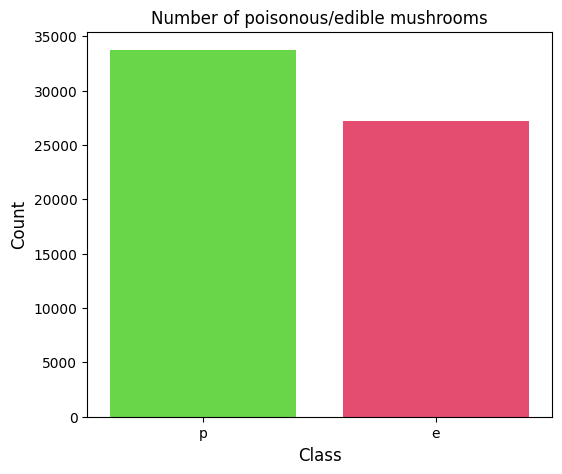

In [21]:
count = df_no_dups['class'].value_counts()
plt.figure(figsize=(6,5))
sns.barplot(x= count.index, y= count.values, hue=count.index, alpha=0.8, palette="prism", legend= False)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.title('Number of poisonous/edible mushrooms')
plt.show();

## 6. Visualizing the Data

### 6.1. Preparing the Data for Visualization

In this step, we create a separate copy of the cleaned dataset for visualization and convert the target label (class) into numeric form (e → 0, p → 1). We then split the predictors into numerical features (cap-diameter, stem-height, stem-width) and categorical features (all remaining columns). To make the dataset plot-ready, missing values in categorical columns are replaced with a "missing" category, categorical variables are temporarily ordinal-encoded, and numerical variables are standardized to keep feature ranges comparable in plots.

In [22]:
df_plot = df_no_dups.copy()

# target
df_plot["class"] = df_plot["class"].map({"e": 0, "p": 1})

# features
X = df_plot.drop(columns=["class"])
num_cols = ["cap-diameter", "stem-height", "stem-width"]
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric:", num_cols)
print("Categorical:", cat_cols)


Numeric: ['cap-diameter', 'stem-height', 'stem-width']
Categorical: ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']


In [23]:
df_enc = df_plot.copy()

# fill NaNs in categoricals to make "missing" an explicit category
df_enc[cat_cols] = df_enc[cat_cols].fillna("missing")

# ordinal encode categoricals (temporary for plotting)
oe = OrdinalEncoder()
df_enc[cat_cols] = oe.fit_transform(df_enc[cat_cols])

# scale numeric (optional but makes violin ranges nicer)
scaler = StandardScaler()
df_enc[num_cols] = scaler.fit_transform(df_enc[num_cols])

df_enc.head()


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,1,1.616820,6.0,2.0,6.0,0.0,2.0,3.0,10.0,3.082356,...,5.0,8.0,11.0,1.0,5.0,1.0,2.0,2.0,0.0,3.0
1,1,1.871167,6.0,2.0,6.0,0.0,2.0,3.0,10.0,3.391996,...,5.0,8.0,11.0,1.0,5.0,1.0,2.0,2.0,0.0,2.0
2,1,1.390945,6.0,2.0,6.0,0.0,2.0,3.0,10.0,3.335427,...,5.0,8.0,11.0,1.0,5.0,1.0,2.0,2.0,0.0,3.0
3,1,1.409926,2.0,3.0,1.0,0.0,2.0,3.0,10.0,2.731032,...,5.0,8.0,11.0,1.0,5.0,1.0,6.0,2.0,0.0,3.0
4,1,1.499137,6.0,3.0,6.0,0.0,2.0,3.0,10.0,2.957308,...,5.0,8.0,11.0,1.0,5.0,1.0,6.0,2.0,0.0,3.0


### 6.2. Box Plot (Numeric Features vs. Class)
We use box plots to compare the distribution of numerical features between edible (e) and poisonous (p) mushrooms. A box plot highlights the median, spread (IQR), and outliers, making it easy to see whether the two classes differ in typical values or variability. We only plot three columns because they are the only continuous numeric features in this dataset (cap-diameter, stem-height, stem-width); the remaining features are categorical, so box plots are not appropriate for them.

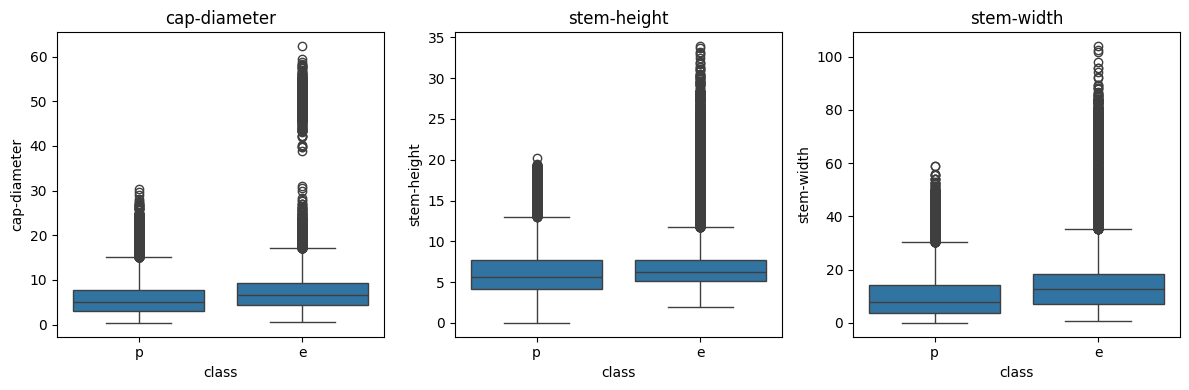

In [24]:
num_cols = ["cap-diameter", "stem-height", "stem-width"]

plt.figure(figsize=(12, 4))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=df, x="class", y=col)
    plt.title(col)
plt.tight_layout()
plt.show()


**!Conclusion:**
From the plots, edible mushrooms generally show slightly higher median values for cap diameter, stem height, and stem width compared to poisonous ones, although the distributions overlap considerably. All three features contain many outliers, suggesting wide natural variation in mushroom size.

### 6.3. Correlation Heatmap (Ordinal-Encoded Features)
We use a correlation heatmap to get a quick overview of how features relate to each other and to the target class. Since most variables are categorical, they are temporarily ordinal-encoded only for visualization so that a correlation matrix can be computed (this does not imply a true numeric order in the original categories).

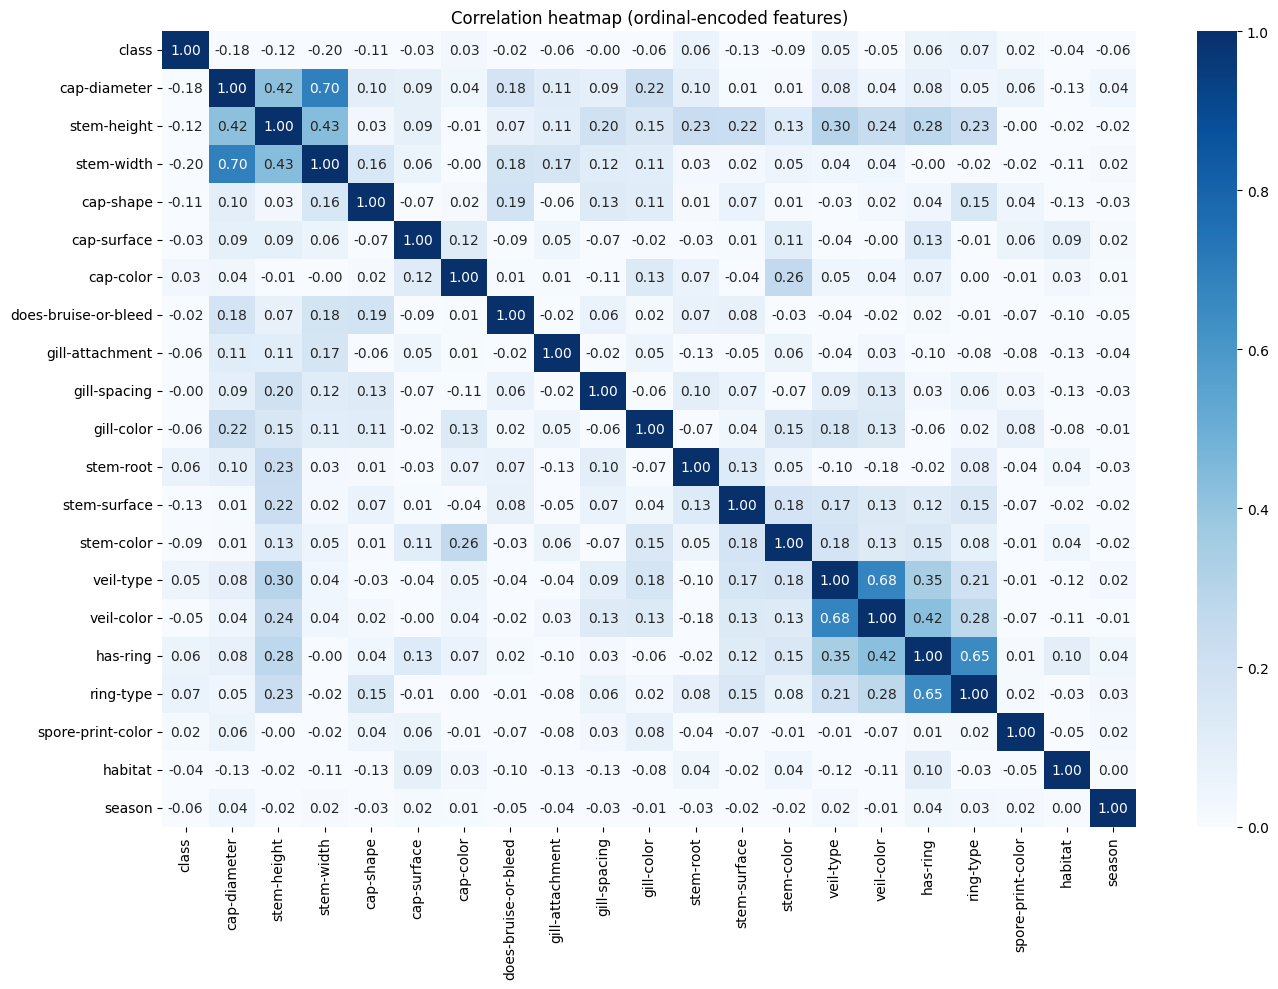

In [25]:
# Build the list of columns to include in the correlation matrix
cols_for_corr = ["class"] + num_cols + cat_cols

# Correlation on the temporary ordinal-encoded dataset (for visualization only)
corr = df_enc[cols_for_corr].corr(numeric_only=True)

# Plot correlation heatmap (values scaled between 0 and 1 for readability)
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="Blues", vmin=0, vmax=1, annot=True, fmt=".2f")
plt.title("Correlation heatmap (ordinal-encoded features)")
plt.tight_layout()
plt.show()


**!Conclusion:**
Overall, the target class shows weak linear correlations with most individual features, suggesting that edibility is likely determined by combinations of attributes rather than a single feature. The heatmap also highlights a few strong correlations between some features (e.g., some size measurements and some related categorical attributes), which may indicate redundancy—something tree-based models can handle well but that is still useful to know during analysis

### 6.4. Categorical Association Heatmap (Cramér’s V)
Because the majority of variables in this dataset are categorical, a standard correlation matrix (Pearson) is not appropriate. Instead, we compute Cramér’s V, which measures the strength of association between two categorical features on a scale from 0 (no relationship) to 1 (very strong relationship). We also include the target (class) to see which attributes are most related to edibility/poisonousness, and we plot a selected subset of columns to keep the heatmap readable.

In this step, we replace ? and NaN values with a separate "missing" label only for the categorical association analysis, so the chi-square contingency tables can be computed without dropping rows.

In [26]:
def cramers_v(x, y):
    # Cramér’s V (0..1): strength of association between two categorical variables
    table = pd.crosstab(x, y)
    chi2 = chi2_contingency(table, correction=False)[0]
    n = table.to_numpy().sum()

    # Bias-corrected version
    r, k = table.shape
    phi2 = chi2 / n
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)

    denom = min(kcorr - 1, rcorr - 1)
    return np.sqrt(phi2corr / denom) if denom > 0 else 0.0

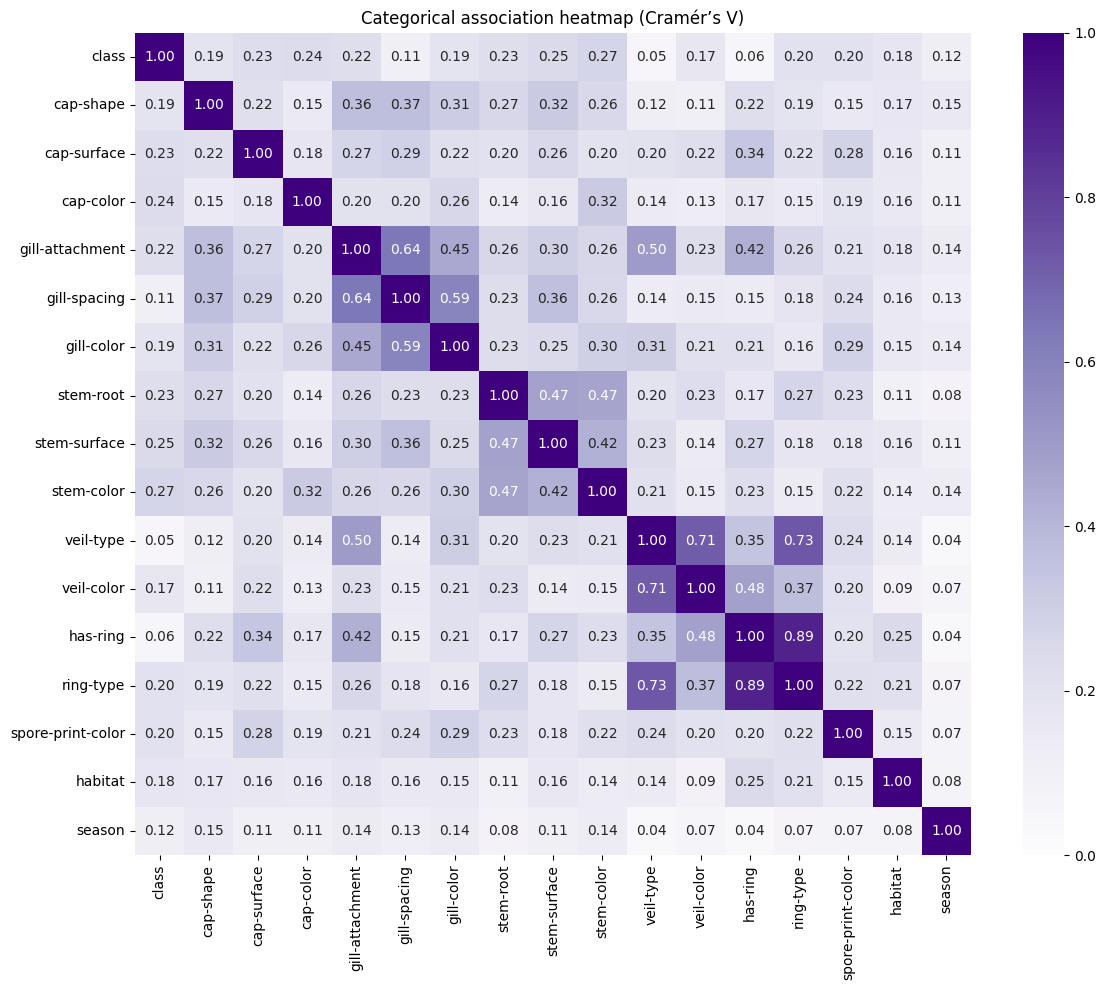

In [27]:
# Prepare categorical data (include target 'class')
df_cat = df_no_dups[cat_cols + ["class"]].copy()
df_cat = df_cat.replace("?", np.nan).fillna("missing")

# Subset of columns to keep the heatmap readable
subset = ["class", "cap-shape", "cap-surface", "cap-color",
          "gill-attachment", "gill-spacing", "gill-color",
          "stem-root", "stem-surface", "stem-color",
          "veil-type", "veil-color",
          "has-ring", "ring-type",
          "spore-print-color", "habitat", "season"]
subset = [c for c in subset if c in df_cat.columns]

# Compute pairwise Cramér’s V matrix
V = pd.DataFrame(index=subset, columns=subset, dtype=float)
for c1 in subset:
    for c2 in subset:
        V.loc[c1, c2] = cramers_v(df_cat[c1], df_cat[c2])

# Plot association heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(V, annot=True, fmt=".2f", cmap="Purples", vmin=0, vmax=1)
plt.title("Categorical association heatmap (Cramér’s V)")
plt.tight_layout()
plt.show()


**Conclusion:**
The class row/column shows mostly weak-to-moderate associations with individual features (around 0.05–0.27 in this subset), suggesting that the target is not determined by a single categorical attribute but rather by combinations of multiple features. The heatmap also reveals some strong dependencies between predictors, such as has-ring ↔ ring-type (≈ 0.89) and veil-type ↔ veil-color (≈ 0.71), indicating overlapping information among certain variables—useful context when interpreting the dataset and model behavior.

## 7. Data Preprocessing and Train/Test Split

In this section, we prepare the dataset for modeling by:

* Creating a clean working copy and separating features (X) from the target (y), mapping class to numeric labels (e → 0, p → 1).

* Splitting the predictors into numeric (cap-diameter, stem-height, stem-width) and categorical columns, and converting "?" in categorical fields into missing values.

* Performing a stratified train/test split (80/20) to preserve the class distribution in both sets.

* Building consider pipeline-based preprocessing:

  * Numeric: median imputation + standardization

  * Categorical: fill missing with "missing" + one-hot encoding (ignoring unseen categories)

* Fitting the preprocessing on the training set and transforming both train and test data into model-ready numeric matrices.

In [28]:
# Copy data and split into features/target (encode class: e=0, p=1)
df_prep = df_no_dups.copy()
y = df_prep["class"].map({"e": 0, "p": 1})
X = df_prep.drop(columns=["class"])

# Separate numeric and categorical columns + mark "?" as missing in categoricals
num_cols = ["cap-diameter", "stem-height", "stem-width"]
cat_cols = [c for c in X.columns if c not in num_cols]
X[cat_cols] = X[cat_cols].replace("?", np.nan)

print("X shape:", X.shape)
print("Numeric:", num_cols)
print("Categorical:", len(cat_cols))

X shape: (60923, 20)
Numeric: ['cap-diameter', 'stem-height', 'stem-width']
Categorical: 17


In [29]:
# Stratified train/test split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)

(48738, 20) (12185, 20)


In [30]:
# Preprocessing pipelines: numeric (impute+scale), categorical (impute+one-hot)
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine preprocessing for numeric + categorical columns
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

In [31]:
# Fit on training data, then transform train and test (Just to check their shape)
X_train_tr = preprocess.fit_transform(X_train)
X_test_tr = preprocess.transform(X_test)

print("Train transformed:", X_train_tr.shape)
print("Test transformed:", X_test_tr.shape)


Train transformed: (48738, 128)
Test transformed: (12185, 128)


## 8. Classification Methods

In this section, we train and compare three classifiers — Decision Tree, Random Forest and Logistic Regression—to predict mushroom edibility. Each model is evaluated on the same train/test split to measure performance and identify the best approach.

In [32]:
# Store model results for later comparison
all_models = []

### 8.1. Decision Tree Classification

#### 8.1.1. Train Decision Tree pipeline

I build a pipeline that applies the preprocessing steps and then trains a Decision Tree classifier. Fitting the pipeline ensures the preprocessing is learned from the training set and applied consistently during prediction.

In [33]:
dt_model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(random_state=42))
])

dt_model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cap-diameter',
                                                   'stem-height',
                                                   'stem-width']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cap-shape', 'cap-surface',
                                                   'cap-color',
                                                   'does-bruise-or-bleed',
                                                   'gill-attachment',
                                                   'gill-spacing', 'gill-color',
                                                   'stem-root', 'stem-surface',
                                                   'stem-color', 'veil-type',
                                                   'veil-color', 'has-ring',
                                                   'ring-type',
                                                   'spore-print-color',
                                                   'habitat', 'season'])])),
                ('clf', DecisionTreeClassifier(random_state=42))])

#### 8.1.2. Feature Importance

In this part, I extract the Decision Tree’s `feature_importances_` to understand which inputs contribute most to the predictions.

Since one-hot encoding expands categorical variables into many columns, I map transformed names back to the original features, aggregate their importances, and plot the top 20 most influential features.

In [34]:
def original_feature_name(transformed_name: str) -> str:
    # Names look like: "num__cap-diameter" or "cat__cap-color_b"
    if transformed_name.startswith("num__"):
        return transformed_name.replace("num__", "")
    if transformed_name.startswith("cat__"):
        rest = transformed_name.replace("cat__", "")
        # split at the first underscore (feature_value)
        return rest.split("_", 1)[0]
    return transformed_name

In [35]:
# Get expanded feature names after preprocessing + DT importances
feature_names = dt_model.named_steps["prep"].get_feature_names_out()
importances = dt_model.named_steps["clf"].feature_importances_

# Importance per transformed column
fi = pd.Series(importances, index=feature_names)

# Aggregate one-hot columns back to original feature names
fi.index = [original_feature_name(n) for n in fi.index]
fi_by_feature = fi.groupby(level=0).sum().sort_values(ascending=False)

# Convert to percentage (easier to read)
fi_pct = (fi_by_feature / fi_by_feature.sum() * 100).round(2)

# Table: top 20
dt_importance_df = fi_pct.head(20).reset_index()
dt_importance_df.columns = ["feature", "participation_%"]
dt_importance_df

,feature,participation_%
0,cap-surface,14.17
1,stem-width,11.72
2,gill-color,9.08
3,stem-surface,9.00
4,gill-attachment,8.77
5,stem-color,8.17
6,gill-spacing,6.24
7,ring-type,5.92
8,stem-root,5.36
9,stem-height,4.68


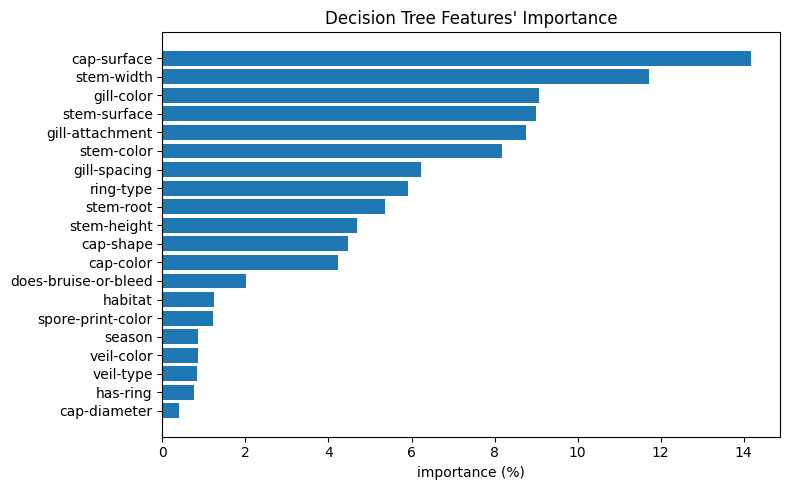

In [36]:
# Plot: top 20 (sorted for nicer horizontal bar chart)
top_m = 20
top_pct = fi_pct.head(top_m).sort_values()

plt.figure(figsize=(8, 5))
plt.barh(top_pct.index, top_pct.values)
plt.title("Decision Tree Features' Importance")
plt.xlabel("importance (%)")
plt.tight_layout()
plt.show()

**!Conclusion:**
The Decision Tree relies most heavily on cap-surface, followed by stem-width and several gill/stem-related features (such as gill-color and stem-surface), suggesting these attributes are the strongest signals for distinguishing edible vs. poisonous mushrooms. In contrast, features like cap-diameter, has-ring, and veil-type/veil-color contribute relatively little in this model.

#### 8.1.3. Predicting over test set

I use the trained Decision Tree pipeline to predict labels for the test set and evaluate performance using accuracy, F1-score, precision, and recall. I also print a full classification report to see how well the model performs on each class (edible vs. poisonous).

In [37]:
# Predict on the held-out test set
y_pred = dt_model.predict(X_test)

# Compute evaluation metrics
acc_dt = accuracy_score(y_test, y_pred)
f1_dt = f1_score(y_test, y_pred)
prec_dt = precision_score(y_test, y_pred)
rec_dt = recall_score(y_test, y_pred)

print(f"Accuracy : {acc_dt *100:.3f}%")
print(f"F1-score  : {f1_dt:.5f}")
print(f"Precision : {prec_dt:.5f}")
print(f"Recall    : {rec_dt:.5f}\n")

# Detailed per-class performance
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["edible (0)", "poisonous (1)"]))


Accuracy : 99.943%
F1-score  : 0.99948
Precision : 0.99941
Recall    : 0.99956

Classification Report:
               precision    recall  f1-score   support

   edible (0)       1.00      1.00      1.00      5436
poisonous (1)       1.00      1.00      1.00      6749

     accuracy                           1.00     12185
    macro avg       1.00      1.00      1.00     12185
 weighted avg       1.00      1.00      1.00     12185



#### 8.1.4. Confusion Matrix

I plot a confusion matrix to visualize how many samples the Decision Tree classified correctly and where it made mistakes (edible vs. poisonous). This helps us understand the types of errors beyond the overall accuracy.

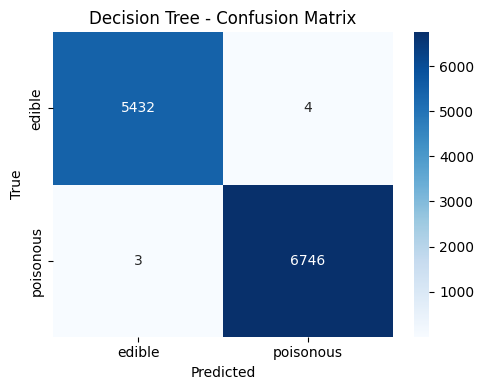

In [38]:
# Build confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["edible", "poisonous"],
            yticklabels=["edible", "poisonous"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Decision Tree - Confusion Matrix")
plt.tight_layout()
plt.show()


**!Conclusion:**
The model makes very few mistakes: only 4 edible mushrooms are predicted as poisonous and 3 poisonous are predicted as edible, showing excellent performance with minimal misclassification.

#### 8.1.5. Cross-Validation Evaluation (5-Fold Stratified)

In this section, I use 5-fold stratified cross-validation on the training set to check whether the Decision Tree’s performance is stable across different splits while keeping the edible/poisonous ratio consistent in each fold. I report the mean ± standard deviation for accuracy, F1-score, and ROC-AUC.

In [39]:
# 5-fold stratified cross-validation (preserves class distribution in each fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Metrics to evaluate across folds
scoring = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# Run CV on the training set (test set remains untouched)
scores_dt = cross_validate(dt_model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

print("CV accuracy:", scores_dt["test_accuracy"].mean().round(5), "+/-", scores_dt["test_accuracy"].std().round(5))
print("CV f1:", scores_dt["test_f1"].mean().round(5), "+/-", scores_dt["test_f1"].std().round(5))
print("CV roc_auc:", scores_dt["test_roc_auc"].mean().round(5), "+/-", scores_dt["test_roc_auc"].std().round(5))

CV accuracy: 0.99865 +/- 0.00015
CV f1: 0.99878 +/- 0.00014
CV roc_auc: 0.99866 +/- 0.00018


**!Conclusion:**
Using 5-fold stratified cross-validation, the Decision Tree achieved accuracy 0.99865 (±0.00015), F1 0.99878 (±0.00014), and ROC-AUC 0.99866 (±0.00018), indicating very high and stable predictive performance across splits.

The high cross-validation scores and low standard deviation suggest the model generalizes well, so the held-out test-set performance is likely reliable.

In [40]:
# Adding the Decision Tree Results to the all_models list
dt_results = {"model": "Decision Tree", "test_acc": round(acc_dt * 100, 3), "test_f1": round(f1_dt, 5)}
all_models.append(dt_results)

In [41]:
all_models

[{'model': 'Decision Tree', 'test_acc': 99.943, 'test_f1': 0.99948}]

### 8.2. Random Forest Classification

#### 8.2.1. Train Random Forest pipeline

In this section, I train a Random Forest model using the same preprocessing pipeline to ensure consistent handling of missing values and categorical features. Random Forest combines many decision trees to improve generalization and reduce overfitting.

In [42]:
# Random Forest pipeline: preprocessing + classifier
rf_model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

In [43]:
rf_model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cap-diameter',
                                                   'stem-height',
                                                   'stem-width']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cap-shape', 'cap-surface',
                                                   'cap-color',
                                                   'does-bruise-or-bleed',
                                                   'gill-attachment',
                                                   'gill-spacing', 'gill-color',
                                                   'stem-root', 'stem-surface',
                                                   'stem-color', 'veil-type',
                                                   'veil-color', 'has-ring',
                                                   'ring-type',
                                                   'spore-print-color',
                                                   'habitat', 'season'])])),
                ('clf',
                 RandomForestClassifier(n_estimators=300, n_jobs=-1,
                                        random_state=42))])

#### 8.2.2. Feature Importance

Here, I extract the Random Forest feature importances to understand which inputs contribute most to the predictions.

Since one-hot encoding expands categorical variables, I aggregate importances back to the original feature level and plot the top 20.

In [44]:
# Extract feature names after preprocessing + RF importances
feature_names = rf_model.named_steps["prep"].get_feature_names_out()
importances = rf_model.named_steps["clf"].feature_importances_

# Importance per transformed column
fi_rf = pd.Series(importances, index=feature_names)

# Aggregate one-hot columns back to original feature names
fi.index = [original_feature_name(n) for n in fi.index]
fi_by_feature = fi.groupby(level=0).sum().sort_values(ascending=False)

# Convert to percentage for readability + show top 20
fi_pct = (fi_by_feature / fi_by_feature.sum() * 100).round(2)
rf_importance_df = fi_pct.head(20).reset_index()
rf_importance_df.columns = ["feature", "participation_%"]
rf_importance_df

,feature,participation_%
0,cap-surface,14.17
1,stem-width,11.72
2,gill-color,9.08
3,stem-surface,9.00
4,gill-attachment,8.77
5,stem-color,8.17
6,gill-spacing,6.24
7,ring-type,5.92
8,stem-root,5.36
9,stem-height,4.68


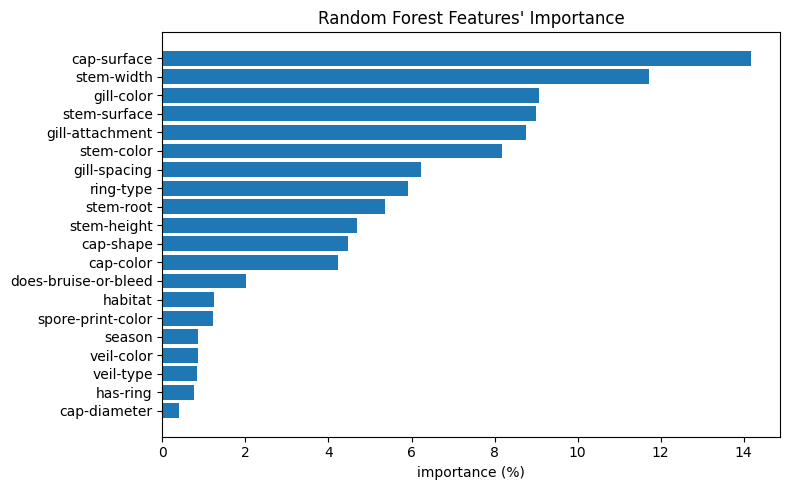

In [45]:
# Plot top 20 feature importances (sorted for nicer horizontal bars)
top_m = 20
top_pct = fi_pct.head(top_m).sort_values()

plt.figure(figsize=(8, 5))
plt.barh(top_pct.index, top_pct.values)
plt.title("Random Forest Features' Importance")
plt.xlabel("importance (%)")
plt.tight_layout()
plt.show()

**!Conclusion:** The most important features in the plot are the ones the Random Forest relies on most, suggesting they provide the strongest signal for distinguishing edible from poisonous mushrooms.

#### 8.2.3. Predicting over test set

I use the trained Random Forest pipeline to predict labels for the test set and evaluate performance using accuracy, precision, recall, and F1-score. The classification report provides per-class performance details.

In [46]:
# Predict on the held-out test set
y_pred_rf = rf_model.predict(X_test)

# Compute evaluation metrics
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)

print("Random Forest Test Results")
print(f"Accuracy : {acc_rf *100:.2f}%")
print(f"F1-score  : {f1_rf:.4f}")
print(f"Precision : {prec_rf:.4f}")
print(f"Recall    : {rec_rf:.4f}\n")

# Detailed per-class performance
print(f"Classification Report: \n{classification_report(y_test, y_pred_rf, target_names=["edible (0)", "poisonous (1)"])}")

Random Forest Test Results
Accuracy : 100.00%
F1-score  : 1.0000
Precision : 1.0000
Recall    : 1.0000

Classification Report: 
               precision    recall  f1-score   support

   edible (0)       1.00      1.00      1.00      5436
poisonous (1)       1.00      1.00      1.00      6749

     accuracy                           1.00     12185
    macro avg       1.00      1.00      1.00     12185
 weighted avg       1.00      1.00      1.00     12185



**!Conclusion:**
On this 20% held-out test split, the Random Forest achieves perfect scores (1.00), meaning it makes no mistakes on this particular test set.

#### 8.2.4. Confusion Matrix

I plot a confusion matrix to visualize correct predictions and misclassifications for both classes. It provides an immediate view of false positives and false negatives.

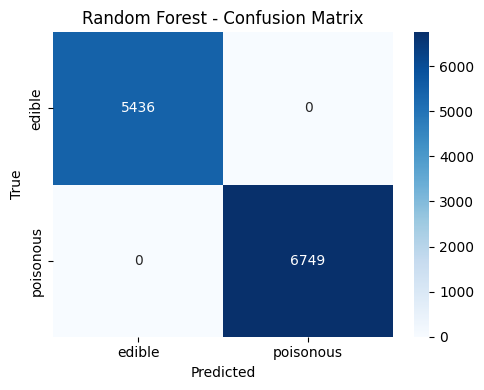

In [47]:
# Confusion matrix (test set)
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["edible", "poisonous"],
            yticklabels=["edible", "poisonous"])
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

**!Conclusion:**
The confusion matrix shows zero misclassifications, meaning there are no false positives or false negatives on the test set.

#### 8.2.5. Cross-Validation Evaluation

To check whether the strong results are stable and not dependent on a single split, I run 5-fold stratified cross-validation on the training set. I report mean ± standard deviation for accuracy, F1-score, and ROC-AUC.

In [48]:
# 5-fold stratified CV on the training set (test set remains untouched)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

scores_rf = cross_validate(rf_model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

print("CV accuracy:", scores_rf["test_accuracy"].mean().round(5), "+/-", scores_rf["test_accuracy"].std().round(5))
print("CV f1:", scores_rf["test_f1"].mean().round(5), "+/-", scores_rf["test_f1"].std().round(5))
print("CV roc_auc:", scores_rf["test_roc_auc"].mean().round(5), "+/-", scores_rf["test_roc_auc"].std().round(5))


CV accuracy: 1.0 +/- 0.0
CV f1: 1.0 +/- 0.0
CV roc_auc: 1.0 +/- 0.0


**!Conclusion:**
The Random Forest achieves perfect cross-validation scores with zero variance, indicating extremely stable performance across folds and supporting the reliability of the test-set results.

In [49]:
# Adding the Random Forest Results to the all_models list
rf_results = {"model": 'Random Forest', "test_acc": round(acc_rf * 100, 3), "test_f1": round(f1_rf, 5)}
all_models.append(rf_results)

In [50]:
all_models

[{'model': 'Decision Tree', 'test_acc': 99.943, 'test_f1': 0.99948},
 {'model': 'Random Forest', 'test_acc': 100.0, 'test_f1': 1.0}]

### 8.3. Logistic Regression Classification

#### 8.3.1. Train Logistic Regression pipeline

In this section, I train a Logistic Regression classifier as a strong linear baseline, using the same preprocessing pipeline for fair comparison with tree-based models. I also use `class_weight="balanced"` to reduce the effect of any class imbalance.

In [51]:
# Logistic Regression pipeline: preprocessing + classifier
lr_model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=5000, n_jobs=-1, class_weight="balanced"))
])

# Fit on training data
lr_model.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cap-diameter',
                                                   'stem-height',
                                                   'stem-width']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cap-shape', 'cap-surface',
                                                   'cap-color',
                                                   'does-bruise-or-bleed',
                                                   'gill-attachment',
                                                   'gill-spacing', 'gill-color',
                                                   'stem-root', 'stem-surface',
                                                   'stem-color', 'veil-type',
                                                   'veil-color', 'has-ring',
                                                   'ring-type',
                                                   'spore-print-color',
                                                   'habitat', 'season'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    n_jobs=-1))])

#### 8.3.2 Feature Participation (Coefficient-Based)

Here, I analyze feature participation using the absolute values of Logistic Regression coefficients.

Since one-hot encoding creates many columns for each categorical feature, I aggregate coefficients back to the original feature level and visualize the top 20.

In [52]:
# Get expanded feature names after preprocessing
feature_names = lr_model.named_steps["prep"].get_feature_names_out()

# Binary LR => coef_ has shape (1, n_features)
coef = lr_model.named_steps["clf"].coef_.ravel()

# Rank transformed features by absolute coefficient magnitude
abs_coef = pd.Series(np.abs(coef), index=feature_names)

# Aggregate one-hot columns back to original feature names
abs_coef.index = [original_feature_name(n) for n in abs_coef.index]
coef_by_feature = abs_coef.groupby(level=0).sum().sort_values(ascending=False)

# Convert to percentage participation (easier to interpret)
lr_participation = (coef_by_feature / coef_by_feature.sum() * 100).round(2)
lr_participation_df = lr_participation.head(20).reset_index()
lr_participation_df.columns = ["feature", "participation_%"]
lr_participation_df

,feature,participation_%
0,veil-color,14.23
1,ring-type,12.00
2,stem-surface,10.28
3,stem-color,10.10
4,stem-root,9.63
5,spore-print-color,8.70
6,gill-attachment,5.63
7,cap-surface,5.61
8,veil-type,5.59
9,cap-color,5.17


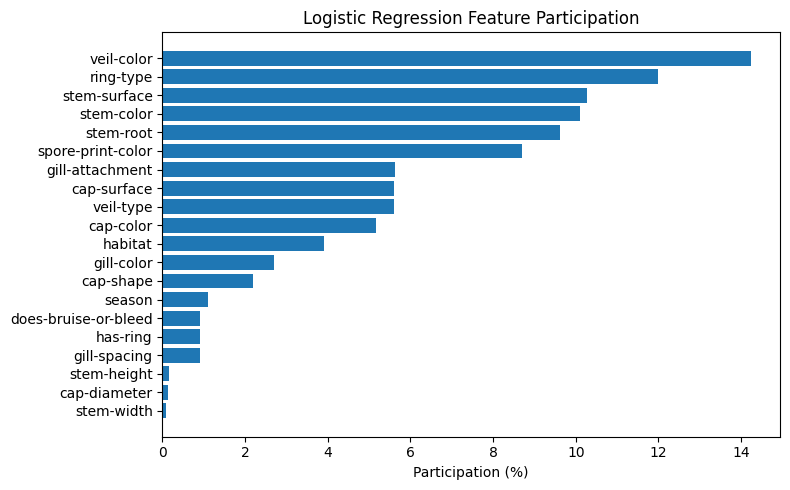

In [53]:
# Plot top 20 (sorted for nicer horizontal bars)
top_m = 20
top_pct = lr_participation.head(top_m).sort_values()

plt.figure(figsize=(8, 5))
plt.barh(top_pct.index, top_pct.values)
plt.xlabel("Participation (%)")
plt.title("Logistic Regression Feature Participation")
plt.tight_layout()
plt.show()

**!Conclusion:**
Features with the highest participation have the strongest influence in the linear decision boundary learned by Logistic Regression.

#### 8.3.3. Predicting on the Test Set

I predict labels for the held-out test set and evaluate Logistic Regression using accuracy, precision, recall, and F1-score. The classification report provides class-wise performance.

In [54]:
# Predict on the held-out test set
y_pred_lr = lr_model.predict(X_test)

# Compute evaluation metrics
acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("Logistic Regression Test Results:")
print(f"Accuracy : {acc_lr:.4f}")
print(f"Precision: {prec_lr:.4f}")
print(f"Recall   : {rec_lr:.4f}")
print(f"F1-score : {f1_lr:.4f}\n")

# Detailed per-class performance
print(f"Classification Report: \n{classification_report(y_test, y_pred_lr, target_names=["edible (0)", "poisonous (1)"])}")

Logistic Regression Test Results:
Accuracy : 0.8675
Precision: 0.8976
Recall   : 0.8586
F1-score : 0.8777

Classification Report: 
               precision    recall  f1-score   support

   edible (0)       0.83      0.88      0.86      5436
poisonous (1)       0.90      0.86      0.88      6749

     accuracy                           0.87     12185
    macro avg       0.87      0.87      0.87     12185
 weighted avg       0.87      0.87      0.87     12185



#### 8.3.4. Confusion Matrix

I plot a confusion matrix to visualize correct predictions and misclassifications for both classes. This makes it easy to see false positives and false negatives.

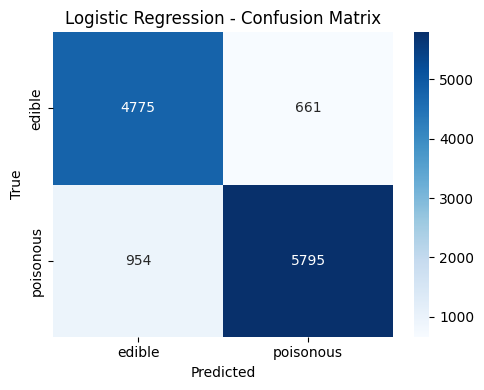

In [55]:
# Confusion matrix (test set)
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=["edible", "poisonous"],
            yticklabels=["edible", "poisonous"])
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

#### 8.3.5 Logistic Regression Tuning and Cross-Validation

In this section, I tune Logistic Regression by searching for the best regularization strength (C) using 5-fold stratified cross-validation optimized for F1-score. After selecting the best setting, I run cross-validation again on the training set to report stability across accuracy, F1, and ROC-AUC while keeping the test set untouched.

(This step can take longer than previous ones because it runs multiple cross-validation fits during hyperparameter search.)

In [57]:
# Tune regularization strength (C) with 5-fold stratified CV (optimize F1)
lr_model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(
        max_iter=5000, n_jobs=-1, class_weight="balanced",
        random_state=42, solver="saga"
    ))
])

param_grid = {"clf__C": [0.001, 0.01, 0.1, 1, 10]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(lr_model, param_grid=param_grid, scoring="f1", cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['cap-diameter',
                                                                          'stem-height',
                                                                          'stem-width']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing'...
                                                                          'gill-attachment',
                                                                          'gill-spacing',
                                                                          'gill-color',
                                                                          'stem-root',
                                                                          'stem-surface',
                                                                          'stem-color',
                                                                          'veil-type',
                                                                          'veil-color',
                                                                          'has-ring',
                                                                          'ring-type',
                                                                          'spore-print-color',
                                                                          'habitat',
                                                                          'season'])])),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=5000,
                                                           n_jobs=-1,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1, param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10]},
             scoring='f1')

In [58]:
print("Best C:", grid.best_params_)
print("Best CV F1:", round(grid.best_score_, 4))

Best C: {'clf__C': 10}
Best CV F1: 0.8778


In [59]:
# Stability check of the tuned model (still only on training set)
scoring = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}
lr_cv = cross_validate(grid.best_estimator_, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

print("CV accuracy:", lr_cv["test_accuracy"].mean().round(5), "+/-", lr_cv["test_accuracy"].std().round(5))
print("CV f1:", lr_cv["test_f1"].mean().round(5), "+/-", lr_cv["test_f1"].std().round(5))
print("CV roc_auc:", lr_cv["test_roc_auc"].mean().round(5), "+/-", lr_cv["test_roc_auc"].std().round(5))

CV accuracy: 0.86854 +/- 0.00229
CV f1: 0.87781 +/- 0.00203
CV roc_auc: 0.93738 +/- 0.00158


**!Conclusion:**
With C = 100, Logistic Regression reaches a best CV F1 ≈ 0.878. The cross-validation results (accuracy ≈ 0.869, ROC-AUC ≈ 0.938) are stable but noticeably lower than the tree-based models, indicating the dataset benefits from non-linear modeling.

In [60]:
# Adding the Random Forest Results to the all_models list
rf_results = {"model": 'Logistic Regression', "test_acc": round(acc_lr * 100, 3), "test_f1": round(f1_lr, 5)}
all_models.append(rf_results)

In [61]:
all_models

[{'model': 'Decision Tree', 'test_acc': 99.943, 'test_f1': 0.99948},
 {'model': 'Random Forest', 'test_acc': 100.0, 'test_f1': 1.0},
 {'model': 'Logistic Regression', 'test_acc': 86.746, 'test_f1': 0.8777}]

## 9. Final Conclusion (Model Comparison)

In this section, I convert the saved results into a table and visualize the models’ test accuracy and test F1-score side by side. This makes it easier to compare overall performance and choose the best classifier.

In [62]:
# Convert to DataFrame and show it
df_compare = pd.DataFrame(all_models)
df_compare

,model,test_acc,test_f1
0,Decision Tree,99.943,0.99948
1,Random Forest,100.000,1.00000
2,Logistic Regression,86.746,0.87770


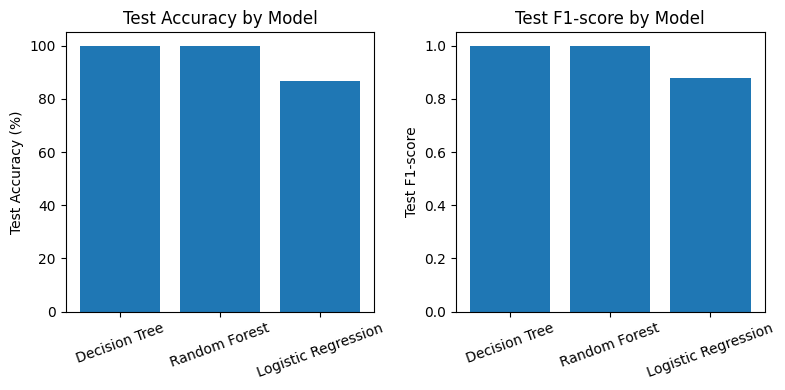

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Accuracy plot
axes[0].bar(df_compare["model"], df_compare["test_acc"])
axes[0].set_title("Test Accuracy by Model")
axes[0].set_ylabel("Test Accuracy (%)")
axes[0].tick_params(axis="x", rotation=20)

# F1 plot
axes[1].bar(df_compare["model"], df_compare["test_f1"])
axes[1].set_title("Test F1-score by Model")
axes[1].set_ylabel("Test F1-score")
axes[1].tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()

**!Final Conclusion:**

Random Forest achieved the best performance with 100% accuracy and 1.00 F1, followed very closely by the Decision Tree (99.943% accuracy, 0.99948 F1). Logistic Regression performed significantly worse (86.746% accuracy, 0.8777 F1), which suggests that the mushroom classification patterns in this dataset are better captured by non-linear, tree-based models rather than a linear classifier.